# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 2
# Simple Linear Regression

# SOLUTIONS

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your partner (one) below. 

---

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
%matplotlib inline


# Set the styles
sns.set_style('darkgrid')
sns.set_context('notebook')
sns.set_palette('Dark2')

C:\Users\Goodwin.Chen\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Predicting Taxi Pickups in NYC

In this homework, we will explore k-nearest neighbor, linear and polynomial regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in files `dataset_1_train.txt` and `dataset_1_test.txt` as separate training and test sets. The first column in each file contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded during different days in Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pick ups at that time. The models will be fitted to the training set, and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric. 

**Data Normalization:** As a first step, we suggest that you normalize the `TimeMin` predictor to a value between 0 and 1. This can be done by dividing the time column in the training and test sets by 1440 (i.e. the maximum value the predictor can take). This normalization step would be particularly helpful while fitting polynomial regression models on this data.

Generate a scatter plot of the training data points, with the time of the day on the X-axis and the number of taxi pickups on the Y-axis. Does the pattern of taxi pickups make intuitive sense to you?

In [2]:
train_data = pd.read_csv('dataset_1_train.txt')
test_data = pd.read_csv('dataset_1_test.txt')
train_data.head()

,TimeMin,PickupCount
0,860.0,33.0
1,17.0,75.0
2,486.0,13.0
3,300.0,5.0
4,385.0,10.0


In [3]:
train_data.describe()

,TimeMin,PickupCount
count,250.000000,250.000000
mean,701.416000,32.780000
std,409.247928,18.910368
min,4.000000,1.000000
25%,381.500000,18.000000
50%,686.000000,32.000000
75%,1032.750000,44.000000
max,1438.000000,95.000000


Text(0,0.5,'Pickup count')

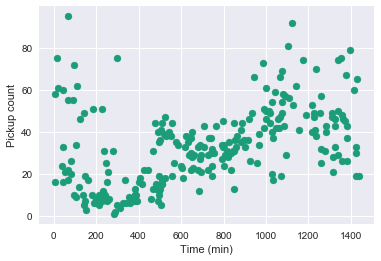

In [10]:
# Plot the results and label
plt.scatter(train_data['TimeMin'], train_data['PickupCount'])
plt.gca().set_xlabel('Time (min)')
plt.gca().set_ylabel('Pickup count')

<font color='blue'>

Yes, the pattern makes intuitive sense. It looks like there may be the fewest pickups early in the morning when most people are asleep. There may also be more pickups during commuting hours.

**Note: any comment here that addresses the underlying forces driving this pattern is acceptable**

In [11]:
train_data['NormTimeMin'] = train_data['TimeMin'] / 1440
test_data['NormTimeMin'] = test_data['TimeMin'] / 1440

In [12]:
train_data = train_data.sort_values(['NormTimeMin'])
test_data = test_data.sort_values(['NormTimeMin'])

# Part (a): k-Nearest Neighbors

We begin with k-Nearest Neighbors (k-NN), a non-parametric regression technique. You may use `sklearn`'s built-in functions to run k-NN regression. Create a `KNeighborsRegressor` object, use the `fit` method in the object to fit a k-NN regressor model, use the `predict` method to make predictions from the model, and the `score` method to evaluate the $R^2$ score of the model on a data set.

- Fit k-NN regression models:
    - Fit a k-NN regression model to the training set for different values of $k$ (e.g. you may try out values 1, 2, 10, 25, 50, 100 and 200). 
    - If you are using `sklearn`'s built-in functions for k-NN regression, explain what happens when you invoke the `fit` function. 
    - If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?
    
<font color='blue'> When you invoke the fit function, sklearn learns the uniformly weighted average of the $k$ nearest points to every possible point in the space (or learns the data necessary to predict it later, i.e. just the points and their y values). When we ask it to predict on any of these possible points, it returns this weighted average of the y values of the $k$ nearest points. <br><br> If $k=n$, all points will receive the same predicted value, equal to the average of all of the points </font>    

- Visualize the fitted models: 
    - Generate a scatter plot of the training data points, and in the same figure, also generate line plots of the predicted values $\hat{y}$ from each fitted model as a function of the predictor variable $x$. (*Hint:* you may want to sort the $x$ values before plotting.)
    - How does the value of $k$ effect the fitted model?
    

In [16]:
test_data.shape

(1000, 3)

In [13]:
print(train_data['NormTimeMin'].shape)
print(test_data.PickupCount.shape)


(250,)
(1000,)


---

---

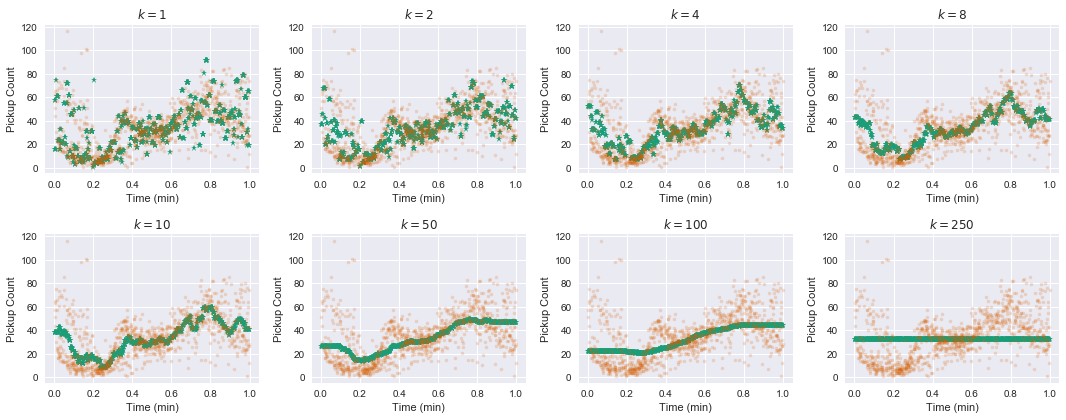

In [17]:
fig, axs = plt.subplots(2,4, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
K = [1, 2, 4,8, 10, 50, 100, 250]
axs = axs.ravel()

n_train = train_data.shape[0]
n_test = test_data.shape[0]
r2_test = []
r2_train = []

for i,k in enumerate(K): 
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(train_data[['NormTimeMin']], train_data[['PickupCount']])
    predicted_pickups_train = knn_model.predict(train_data[['NormTimeMin']])
    predicted_pickups = knn_model.predict(test_data[['NormTimeMin']])

    r2_train.append( r2_score(train_data[['PickupCount']], predicted_pickups_train))
    r2_test.append( r2_score(test_data[['PickupCount']], predicted_pickups))
    
    axs[i].plot(test_data['NormTimeMin'], predicted_pickups, '*', 
                label='Predicted')
    axs[i].plot(test_data['NormTimeMin'], test_data['PickupCount'], '.', 
                alpha=0.2, label='Actual')
    
    
    # Set labels
    axs[i].set_title("$k = " + str(k) + "$")
    axs[i].set_xlabel('Time (min)')
    axs[i].set_ylabel('Pickup Count')

fig.tight_layout()

In [18]:
print(r2_train, r2_test)

[0.87897968282704175, 0.6468303480681783, 0.52307258636005782, 0.4682429761384681, 0.45097913477660767, 0.35433154580544879, 0.2869537997976257, 0.0] [0.026793114990582345, 0.23541124628516041, 0.36825011538591534, 0.39516433986818889, 0.41540664874257371, 0.38050111639302864, 0.31163937860854973, -0.00086067546046031396]


<font color='blue'>The lower the value of $k$, the more variance in the predictions. The higher the value of $k$, the smoother the prediction. The ideal value of $k$ looks to be around 10.</font>

- Evaluate the fitted models:
    - Compute the $R^2$ score for the fitted models on both the training and test sets. Are some of the calculated $R^2$ values negative? If so, what does this indicate? What does a $R^2$ score of 0 mean?
    - Make plots of the training and test $R^2$ values as a function of $k$. Do the training and test $R^2$ plots exhibit different trends? Explain how the value of $k$ influences the training and test $R^2$ values.

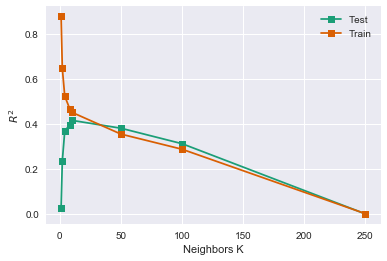

In [22]:
plt.plot(K, r2_test, 's-', label='Test')
plt.plot(K, r2_train, 's-', label='Train')
plt.xlabel('Neighbors K')
plt.ylabel('$R^2$')
plt.legend()

<font color='blue'>Some of the $R^2$ are negative, implying that the chosen model fits worse than a horizontal line. An $R^2$ of 0 indicates that the model explains none of the variation around the mean. This is true for $n=250$, which is exactly a horizontal line centered at the mean. <br><br> The training and test plots of $R^2$ exhibit different trends, as for small $k$, the model overfits the data, so it achieves a very good $R^2$ on the training set and a very poor $R^2$ on the test data. On the test set, greater $k$ decreases overfitting, but too large of $k$ does not allow for enough variation for an accurate prediction, so the test $R^2$ increases to a point and then decreases. Because the training $R^2$ benefits from the overfitting, the training $R^2$ only decreases as $k$ increases. </font>   

# Part (b): Simple Linear Regression

We next consider parametric approaches for regression, starting with simple linear regression, which assumes that the response variable has a linear relationship with the predictor. Do you see any advantages in using a parametric regression model over k-NN regression?

We suggest that you use the `statsmodels` module for linear regression. This module has built-in functions to summarize the results of regression, and to compute confidence intervals for estimated regression parameters. Create a `OLS` class instance, use the `fit` method in the instance for fitting a linear regression model, and use the `predict` method to make predictions. To include an intercept term in the regression model, you will need to append a column of 1's to the array of predictors using the `sm.add_constant` method. The `fit` method returns a `results` instance. Use the  `results.summary` method to obtain a summary of the regression fit, the `results.params` attribute to get the estimated regression parameters, and the `conf_int` method to compute confidence intervals for the estimated parameters. You may use the `r2_score` function to compute $R^2$.

Using the suggested built-in functions, answer the following questions:

- Fit a linear regression model to the training set, and evaluate its $R^2$ value on both the training and test sets. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression in Part (a)?

In [23]:
X_train = sm.add_constant(train_data[['NormTimeMin']].values)
model = sm.OLS(train_data['PickupCount'].values, X_train)
results = model.fit()

y_hat_train = results.predict(X_train)

# test case
X_test = sm.add_constant(test_data[['NormTimeMin']].values)
y_hat_test = results.predict(X_test)

r2_score_train = r2_score(train_data[['PickupCount']].values, y_hat_train) 
r2_score_test = r2_score(test_data[['PickupCount']].values, y_hat_test)

print(r2_score_train , r2_score_test)

0.207213752099 0.247712329948


In [27]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

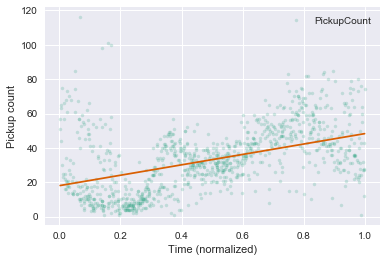

In [24]:
plt.plot(test_data['NormTimeMin'], test_data['PickupCount'], '.', alpha=0.2)
plt.plot(X_train[:,1], y_hat_train)
plt.xlabel('Time (normalized)')
plt.ylabel('Pickup count') 
plt.gca().legend()

<font color='blue'>The $R^2$ is less than the best case $R^2$ achieved from KNN.</font>

- Compute confidence intervals:
    - Print the slope and intercept values for the fitted linear model. What does the sign of the slope convey about the data?
    - Compute the 95% confidence interval for the slope and intercept. Based on this information, do you consider the estimates of the model parameters to be reliable?
    - Do you expect a 99% confidence interval for the slope and intercept to be tighter or looser than the 95% confidence intervals? Explain your answer.


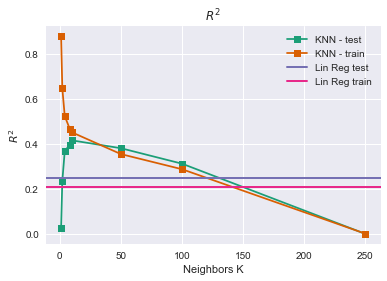

In [25]:
# plotting the knn results just for comparison 
plt.plot(K, r2_test, 's-', label='KNN - test')
plt.plot(K, r2_train, 's-', label='KNN - train')

plt.axhline(y=r2_score_test, linewidth=2, label='Lin Reg test',
            color=sns.color_palette()[2])
plt.axhline(y=r2_score_train, linewidth=2, label ='Lin Reg train',
           color=sns.color_palette()[3])

plt.title('$R^2$')
plt.xlabel('Neighbors K')
plt.ylabel('$R^2$')
plt.legend()

<font color='red'> 
<!-- Why is R2 for test higher then train? 
=== Most likely the split train-test is such.  -->

In the KNN model, why is the $R^2$ for the test set slightly higher than $R^2$ for the training set? This is the consequence of using comparitively few points in our training set. Typically, $R^2$ will be higher on the training set than on the testing set.

In [26]:
print(results.params)
print(results.tvalues)
print(results.summary())
print(results.conf_int())

[ 18.02638518  30.28902299]
[ 8.5009351   8.05113435]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     64.82
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           3.43e-14
Time:                        17:05:59   Log-Likelihood:                -1060.1
No. Observations:                 250   AIC:                             2124.
Df Residuals:                     248   BIC:                             2131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

<font color='blue'>The positive slope implies that the number of pickups increases throughout the day. <br><br> The confidence interval is quite wide, indicating that there are many values potentially consistent with the data. So no, we don't consider the estimates to be reliable. I'd expect a 99% confidence interval to be looser, as it has to allow for an even wider possibility of values </font>


- Analyze residual plots:
    - Make a plot of the residuals ${e} = y - \hat{y}$ of the model on the training set as a function of the predictor variable $x$ (i.e. time of day). Draw a horizontal line denoting the zero residual value on the Y-axis.
    - Using this residual plot, comment on whether the assumption of linearity is valid for this data.

train_data shape:  (250, 3)
residuals shape:  (1, 250)
y_hat_train shape:  (250,)


Text(0,0.5,'Count')

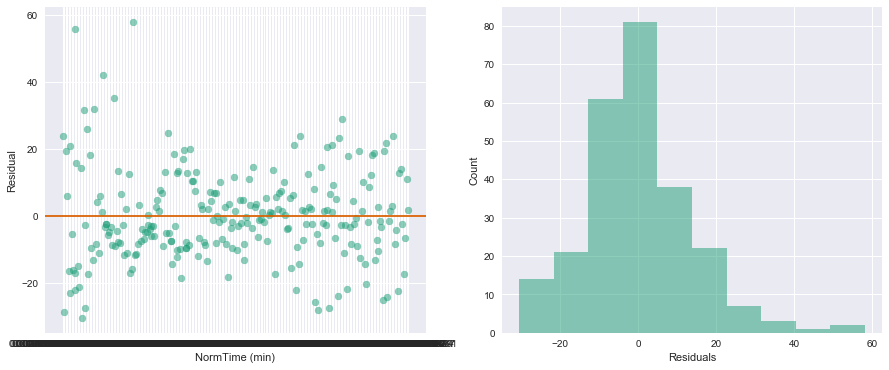

In [46]:
fig, axs = plt.subplots(1,2, figsize=(15, 6))

residuals = (train_data.sort_values(['NormTimeMin'])[['PickupCount']].T - y_hat_train)

print('train_data shape: ', train_data.shape)
print('residuals shape: ', residuals.shape)
print('y_hat_train shape: ', y_hat_train.shape)
    
axs[0].scatter(train_data.sort_values(['NormTimeMin'])[['NormTimeMin']], 
               residuals, alpha=0.5)
axs[0].axhline(y=0, color=sns.color_palette()[1]) 
axs[0].set_xlabel('NormTime (min)')
axs[0].set_ylabel('Residual')

axs[1].hist(residuals.T.values, alpha=0.5)
axs[1].set_xlabel('Residuals')
axs[1].set_ylabel('Count')

<font color='blue'>The assumption of linearity does not seem to be justified, as the residuals are not scattered randomly around 0 and there is a clear structure!</font>

# Part (c): Polynomial Regression

We proceed to higher-order polynomial models for regression:

- By visual inspection, what polynomial degree do you think would provide the best fit for the data?

<font color='blue'>By inspection, I'd expect a polynomial of degree 4 to work best. There are at least 4 modes there.</font>

- At the start of this assignment, we had advised you to normalize the time predictor in the training and test sets to a value in [0,1], and noted that this would be helpful in fitting polynomial regression models. Had the time predictor not been normalized, do you forsee any difficulties in implementing polynomial regression?

<font color='blue'> The values of Y could grow very large at large times and therefore dominate the MSE </font>

- Fit polynomial regression models of degrees 2, 3, 10, 25 and 50 to the training set, and generate visualizations of the fitted models (in the same figure, plot the predicted value from all models as a function of time). 

<font color='blue'>The number of coefficients returned should be the degree of the polynomial + 1 for the constant. If the time predictor were not normalized, the values for the predictor would get very large when squared, cubed, etc. For degree value 50, we would likely run into arithmetic overflow.</font>

In [51]:
X_test

array([[ 1.        ,  0.00277778],
       [ 1.        ,  0.00347222],
       [ 1.        ,  0.00416667],
       ..., 
       [ 1.        ,  0.99652778],
       [ 1.        ,  0.99791667],
       [ 1.        ,  0.99861111]])

In [47]:
gen_poly_terms = PolynomialFeatures(degree=3, interaction_only=False)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
X_test_with_poly = gen_poly_terms.fit_transform(X_test)

poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_with_poly, train_data['PickupCount'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [61]:
X_train[:, 1].reshape(-1, 1).shape

(250, 1)

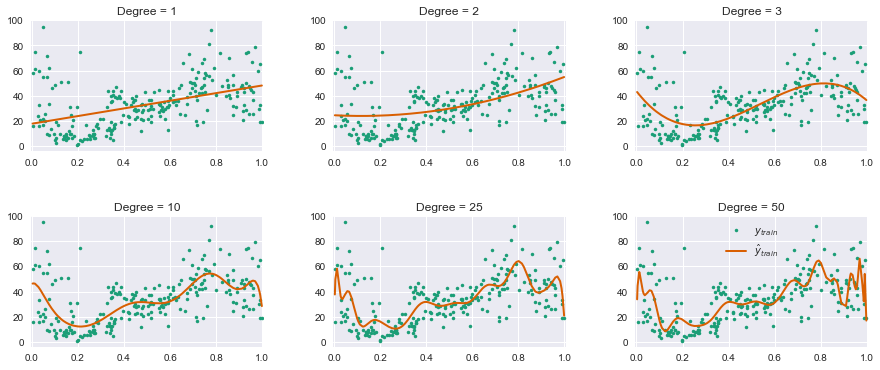

In [76]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
degrees = [1, 2, 3, 10, 25, 50]
# degrees = [1, 2, 3, 9]

r2_train = [] 
r2_test = []

for i,d in enumerate(degrees):
    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)

    X_train_with_poly = gen_poly_terms.fit_transform(X_train[:,1].reshape(-1,1))
    X_test_with_poly = gen_poly_terms.fit_transform(X_test[:,1].reshape(-1,1))
    
    #X_train_with_poly = gen_poly_terms.fit_transform(X_train)
    #X_test_with_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model = LinearRegression(fit_intercept=False)
    poly_regression_model.fit(X_train_with_poly, train_data['PickupCount'])
    
    
    
    y_hat_train = poly_regression_model.predict(X_train_with_poly)
    y_hat_test = poly_regression_model.predict(X_test_with_poly)
    
    
    r2_train.append( r2_score(train_data[['PickupCount']], y_hat_train))
    r2_test.append( r2_score(test_data[['PickupCount']], y_hat_test))
    
    axs[i].plot(train_data[['NormTimeMin']], train_data['PickupCount'], '.', label='$y_{train}$')
    axs[i].plot(train_data[['NormTimeMin']], y_hat_train, lw=2, label='$\hat{y}_{train}$')
    axs[i].set_title("Degree = " + str(d))
    axs[i].set_xlim(-.005,1.005)

# Turn on the legend
axs[i].legend()

- Evaluate the $R^2$ value of the fitted models on both the training and test sets. Does a high training $R^2$ value necessarily indicate a high test $R^2$ performance? How do the test $R^2$ values from the different polynomial models compare with the test $R^2$ from simple linear regression in Part (b), and the best test $R^2$ from k-NN regression in Part (c)?

Polynomial degree [1, 2, 3, 10, 25, 50]
Training R^2 [0.20721375209894033, 0.2324332710285808, 0.3748362391177078, 0.42827706862460924, 0.46662629897482777, 0.48023511095898086]


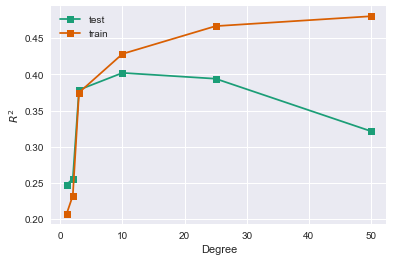

In [77]:
plt.plot(degrees, r2_test, 's-', label='test')
plt.plot(degrees, r2_train, 's-', label='train')
plt.xlabel('Degree')
plt.ylabel('$R^2$')
plt.legend()

# plt.gca().set_yscale('log')
print('Polynomial degree', degrees)
print('Training R^2', r2_train)

<font color='blue'>A high training $R^2$ does not indicate a high test $R^2$. For degrees between 2 and 25, the $R^2$ is better than that of the linear regression and almost as good as that of the best test $R^2$ from KNN.</font>

- Generate residual plots for the different polynomial regression models (plot of residuals on training set vs. time). How does the increase in polynomial degree effect the residual plots?

*Hint:* You may use the `PolynomialFeatures` class to include polynomial terms in the regression model.

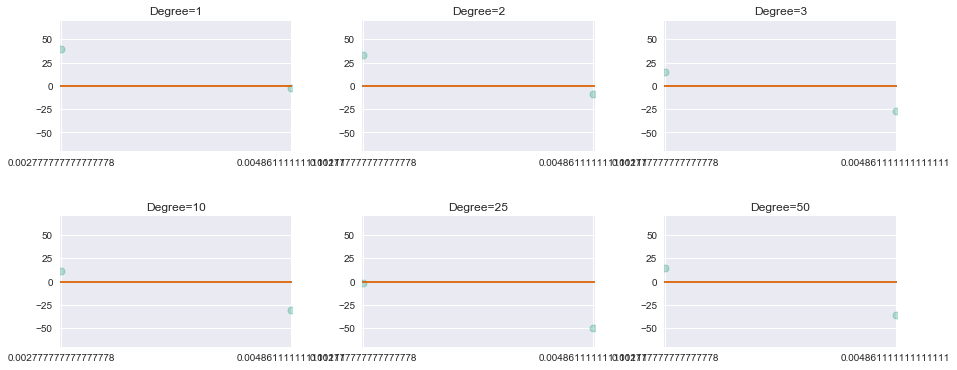

In [79]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.3)
axs = axs.ravel()
degrees = [1, 2, 3, 10, 25, 50]

r2_train = [] 
r2_test = []

i =0 
for i,d in enumerate(degrees):
    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_train_with_poly = gen_poly_terms.fit_transform(X_train)
    X_test_with_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model = LinearRegression(fit_intercept=True)
    poly_regression_model.fit(X_train_with_poly, train_data['PickupCount'])
    
    
    
    y_hat_train = poly_regression_model.predict(X_train_with_poly)
    y_hat_test = poly_regression_model.predict(X_test_with_poly)
    
    r2_train.append( r2_score(train_data[['PickupCount']], y_hat_train))
    r2_test.append( r2_score(test_data[['PickupCount']], y_hat_test))
    
    residuals = train_data['PickupCount'] - y_hat_train
    
    axs[i].scatter(train_data[['NormTimeMin']], residuals, lw=1, alpha=0.3)
    axs[i].axhline(y=0, color=sns.color_palette()[1]) 
    axs[i].set_title("Degree=" + str(d))
    axs[i].set_xlim(-.005,1.005)
    axs[i].set_ylim(-70, 70)


# Part (d): 

In a brief paragraph (8 or fewer sentences), summarize which of the models seen above you would choose to predict the number of taxi cab pick-ups at any specific time of day. Be sure to explain your choice. Interpret the model you choose, including which predictors are significant and provide and interpret the CIs for their coefficients (if you choose a regression model). How well does you model predict the number of taxi cab pick-ups? How would you improve this model even further? Feel free to refer to visual(s) above or provide a new one to make your case.  
  
  
  
<font color=blue>
The answer to this question depends on your analysis above. The "best" model could very well be either kNN or polynomial regression, but a complete answer will give proper justification. Proper justification includes references to the above figures. Additional insight into the computational requirements of each type of model is ideal (which is cheaper to train? Which is cheaper to evaluate?).

# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

### Question 1
Consider a space in $\mathbb{R}^5$, with two subspaces $S_0 \subset \mathbb{R}^5$ and $S_1 \subset \mathbb{R}^5$. For simplicity, let us consider the case where the subspace $S_0$ is spanned by the vectors $v_{00} = [1,0,0,0,0]^T$, $v_{01} =[0,1,0,0,0]^T$ and the subspace $S_1$ is spanned by the vectors $v_{10} = [0,0,0,1,0]^T$ and $v_{11} = [0,0,0,0,1]^T$. 

Now let us assume that we have a dataset that consists of labeled vectors in subspaces $S_0$ and $S_1$ respectively. Our task here is to use the data in the training dataset to classify an unknown vector into either $S_0$ or $S_1$.

Let us consider the case where we construct a predictive matrix $\mathbf{X}$ from the 'training' data for which we know the labels.

```
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
```

(Briefly notice that the training data probably doesn't consist of vectors that are orthonormal in spanning $S_0$ or $S_1$).

And we have an unknown vector, for which we want clasify as either a noisy example of a vector in either $S_0$ or $S_1$: ```y_0 = np.array([2,10,1,0,0])```.

In [19]:
# starter code
dataset = np.array([
            [1,0,0,0,0],
            [1,1,0,0,0],
            [0,0,0,1,1],
            [0,0,0,1,0],
            ])
labels = np.array([0,0,1,1])
y_0 = np.array([2,10,1,0,0])

#### Question 1a
Recall the solution for the Least Squares problem and the 'hat' matrix $\mathbf{H}$. Consider the case when $Y$ lies in the same subspace as the columns of $\mathbf{X}$. In this case, how accurate should the prediction of $\hat{Y}$ be?

#### Question 1a - solution
<font color='blue'>
Note that when $Y$ and $\mathbf{X}$ lie in the same subspace, the vector $Y$ should form a linear combination of the columns of $X$. If this is the case, the orthogonal projection of $Y$ onto the subspace spanned by the columns of $\mathbf{X}$ (i.e. $\hat{Y}$), should present an exact reconstruction of the initial vector $Y$.
</font>

#### Question 1b
Given the projection of $Y$ onto the space spanned by the columns of the X matrix. We can analyse the significance of the different predictor vectors (i.e. the building blocks that are used to reconstrct the $\hat{Y}$ vector). Discuss how this may help one when analysing a classification decision by the model.

#### Question 1b - solution
<font color='blue'>
We could look directly to the significant vectors. One could imagine that in the case of the `face dataset` that if there are many parameters that are significant then there are many combinations of face images that are used to reconstruct the unknown face. If this is the case, and if the $\beta_j$ values are significant, we could believe that the classification of the model would be a robust one. *(note any reasonable answer here is good)*
</font>

#### Question 1c
As discussed in the linked paper, we have data that has vectors that are classified into one subspace or another (our training dataset). We can use the projection interpretation of linear regression to make a classification decision of a new (unseen) vector into either $S_0$ or $S_1$. In other words, construct X matrices from the known vectors, and project the unknown vector onto the subspaces spanned by the various X matrices using the "hat" interpretation of linear regression. To do classification, we can calculate the minimum euclidean distance ($L_2$ norm) between the original vector and the projection. Use this method to classify ```y_0``` as belonging to either $S_0$ or $S_1$.

**Feel free to run this same example on the face data presented in the paper - you will be doing this for next week's homework regardless**

#### Question 1c - solution

In [20]:
X0 = dataset[labels == 0].T
X1 = dataset[labels == 1].T
Hat0 = X0.dot(np.linalg.pinv(X0.T.dot(X0))).dot(X0.T)
Hat1 = X1.dot(np.linalg.pinv(X1.T.dot(X1))).dot(X1.T)
projection_0 = Hat0.dot(y_0)
projection_1 = Hat1.dot(y_0)

print('projection_0', projection_0)
print('projection_1', projection_1)

projection_0 [ 2. 10.  0.  0.  0.]
projection_1 [ 0.  0.  0.  0.  0.]


#### Question 1d

Explicitly derive the relationship between the f-statistic (from the F test) and the $R^2$ measure in linear regression (i.e. write the f-statistic of a linear regression model in terms of the $R^2$ of the same model).

#### Question 1d - solution
Note, we have used $p$ and $J$ interchangeably (to describe the number of parameters in a model) and both should be accepted:
$$
R^2 = \frac{TSS-RSS}{TSS} = 1 - \frac{RSS}{TSS}
$$

$$
F = \frac{(TSS-RSS)/J}{(RSS)/(n-J-1)} = \left[ \frac{R^2}{1 - R^2} \right] \frac{(n-J-1)}{J}
$$